In [61]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
#!apt -qq -y install fonts-nanum
 
# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False


# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")

In [38]:
import os
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))
sub = pd.read_csv(os.path.join(path,"sample_submission.csv"))
#sub = sub.loc[-sub['code'].isin(['C2675', 'C2335', 'C1327']),:].reset_index(drop=True)
#test['단지코드'].unique()

In [66]:
class preprocess:
    
    def __init__(self,train,test,drop_col_name):
        self.train = train
        self.non_unique = np.array(['자격유형', '공급유형', '임대건물구분','임대보증금', '임대료', '전용면적', '전용면적별세대수'])
        self.test = test
        self.drop_col_name = drop_col_name
        
        
    def final(self):

        preprocess.no_duplicates(self,self.train)
        preprocess.process(self,self.train)
        train_res = preprocess.drop_col(self,self.drop_col_name)
        
        print('====train done====')
        
        preprocess.no_duplicates(self,self.test)
        preprocess.process(self,self.test)
        test_res = preprocess.drop_col(self,self.drop_col_name)
        print('====test done====')
        
        return train_res,test_res
        
        
    def no_duplicates(self,df): 
        
        self.newDF = df.drop(self.non_unique,axis=1).drop_duplicates().reset_index(drop=True)
        print(self.newDF.shape)

    def merge(self,col,standard,oldDF,newDF,kind):
        
        sample = oldDF.groupby('단지코드').describe()[col].reset_index()
        for i in sample.index:
            for j in standard:
                code = sample.loc[i,'단지코드']
                val = sample.loc[i,j]
                ind = newDF[newDF['단지코드']==code].index
                newDF.loc[ind,kind+col+j] = val
        return newDF
    
    def category(self,x,dic):
        for i in dic.keys():
            if x in dic[i]:
                return int(i)
        
    def grouping(self,col,dic,oldDF,newDF,count):
        oldDF[col+'카테고리'] = oldDF[col].apply(lambda x : preprocess.category(self,x,dic))
        sample = pd.DataFrame(oldDF.groupby('단지코드')[col+'카테고리'].unique()).reset_index()
        for i in dic.keys():
            newDF[col+str(i)]=0
        for i in sample.index:
            code = sample.loc[i,'단지코드']
            val = sample.loc[i,col+'카테고리']
            ind = newDF[newDF['단지코드']==code].index
            for j in val:
                if count == None:
                  newDF.loc[ind,col+str(j)] = 1  
                else:
                  newDF.loc[ind,col+str(j)] = newDF.loc[ind,count]
        newDF = newDF.drop(col+str(1),axis=1)
        return newDF
                    
    
    def process(self,df):
        
        self.apt = df[df['임대건물구분']=='아파트']
        self.store= df[df['임대건물구분']=='상가']
        
        #아파트 임대료, 임대보증금
        self.newDF = preprocess.merge(self,'임대료',['min','25%','50%','75%','max'],self.apt,self.newDF,'apt')
        self.newDF = preprocess.merge(self,'임대보증금',['min','25%','50%','75%','max'],self.apt,self.newDF,'apt')
        

        #상가 임대료, 임대보증금
        self.newDF = preprocess.merge(self,'임대료',['mean','std'],self.store,self.newDF,'store')
        self.newDF = preprocess.merge(self,'임대보증금',['mean','std'],self.store,self.newDF,'store')

        #상가 없는 경우 임대료 임대보증금 0으로 채움
        self.newDF = self.newDF.replace(np.nan, 0)

#         # 자격유형 0,1 indicator variable
#         dic = {'1': 'A' ,'2':['E','K'],'3':['D'],'4':['L','M','N','O'],'5':['B','H','I','G'],'6':'J','7':['C','F']}
#         self.newDF = preprocess.grouping(self,'자격유형',dic,df,self.newDF,count='세대당_인구')

        
        # 지역
        dic = {'1':['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시'],'2':['경기도' ,'서울특별시', '대구광역시' ,'부산광역시', '대전광역시']}
        self.newDF = preprocess.grouping(self,'지역',dic,self.apt,self.newDF,count=None)

        
        #공급유형
#         df.loc[df['공급유형'].isin(['공공임대(10년)','공공임대(5년)']),'공급유형'] = '공공임대(5,10년)'
#         sample = pd.DataFrame(df.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
#         #sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).count()['지역']).reset_index().rename(columns={'지역':'count'})
#         for i in sample.공급유형.unique():
#             self.newDF[str(i)]=0
#         for i in sample.index:
#             code = sample.loc[i,'단지코드']
#             col = sample.loc[i,'공급유형']
#             val = sample.loc[i,'전용면적별세대수']
#             #val = sample.loc[i,'count']
#             ind = self.newDF[self.newDF['단지코드']==code].index
#             self.newDF.loc[ind,col] = val
            
        # 전용면적(아파트,상가)
        self.newDF = preprocess.merge(self,'전용면적',['min','25%','50%','75%','max'],self.apt,self.newDF,'apt_area')
        self.newDF = preprocess.merge(self,'전용면적',['mean','std'],self.store,self.newDF,'store_area')
        
        self.newDF = self.newDF.replace(np.nan, 0)

        # 공가수
        #self.newDF['공가수'] =  self.newDF.apply(lambda x : x['공가수']*x['세대당_인구'],axis=1)
        self.newDF['공가수'] =  self.newDF.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
        

        # 환승역 수 no_sub는 0으로 만들어주자 
        for ind in range(self.newDF.shape[0]):
            if self.newDF.loc[ind,'지역'] in ['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시']:
                self.newDF.loc[ind,'환승역 수'] = 0
        self.newDF = self.newDF.join(pd.get_dummies(self.newDF['환승역 수'],prefix='sub')).iloc[:,:-1]
        self.newDF = self.newDF.drop('환승역 수',axis=1)
        
        
    def drop_col(self,col):
        self.newDF = self.newDF.drop(col,axis=1)
        return self.newDF

In [67]:
class modeling:

      def __init__(self,train,test,y_name,model_name):
        self.train = train.drop('단지코드',axis=1)
        self.test = test.drop('단지코드',axis=1)
        self.y_name = y_name
        self.model_name = model_name

      def training(self):
        try:
            self.train['등록차량수/총세대수'] = self.train.apply(lambda x : x['등록차량수']/x['총세대수'], axis=1)
            self.train['등록차량수/단지내주차면수'] = self.train.apply(lambda x : x['등록차량수']/x['단지내주차면수'], axis=1)
            self.y = np.array(['등록차량수','등록차량수/단지내주차면수','등록차량수/총세대수'])
        except:
            pass
        X = self.train.drop(['등록차량수','등록차량수/단지내주차면수','등록차량수/총세대수'],axis=1)
        X = pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)
        y = self.train[self.y_name]
        if self.y_name == '등록차량수/총세대수':
            X = X.drop(['총세대수'],axis=1)
        if self.y_name == '등록차량수/단지내주차면수':
            X = X.drop(['단지내주차면수'],axis=1)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3,random_state=2021,shuffle=True)
        self.ind = self.X_test.index
        


      def model(self):

        if self.model_name == 'catboost':
          self.model = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(self.X_train, self.y_train)
          pred = self.model.predict(self.X_test)
          error = modeling.error(self,self.y_name,pred)
          plt.figure(figsize=(12,16))
          sns.barplot(y = self.X_train.columns[np.argsort(self.model.feature_importances_)], x = list(self.model.feature_importances_[np.argsort(self.model.feature_importances_)]))
          return error
        if self.model_name == 'rf':
          self.model = RandomForestRegressor(max_depth=2, random_state=2021)
          self.model.fit(self.X_train, self.y_train)
          pred = self.model.predict(self.X_test)
          error = modeling.error(self,self.y_name,pred)
          return error
        if self.model_name == 'dt':
            self.model = DecisionTreeRegressor(max_depth=2, random_state=2021)
            self.model.fit(self.X_train, self.y_train)
            pred = self.model.predict(self.X_test)
            error = modeling.error(self,self.y_name,pred)
            return error
    
      def error(self,y_name,pred):
          if y_name == '등록차량수/총세대수':
              real_y = np.array(self.train.loc[self.ind,'등록차량수'].values)
              real_pred = np.array(self.train.loc[self.ind,'총세대수'].values) * np.array(pred)
              return mae(real_y,real_pred)
          if y_name == '등록차량수/단지내주차면수':
              real_y = np.array(self.train.loc[self.ind,'등록차량수'].values)
              real_pred = np.array(self.train.loc[self.ind,'단지내주차면수'].values) * np.array(pred)
              return mae(real_y,real_pred)
          if self.y_name == '등록차량수':
              return mae(pred,self.y_test)
        
      def testing(self):
          self.test['공공분양'] = 0
          self.test['장기전세'] = 0
          X = pd.DataFrame(StandardScaler().fit_transform(self.test),columns=self.test.columns)
          X = self.test
          if self.y_name == '등록차량수/총세대수':
              X= X.drop(['총세대수'],axis=1)
              pred = self.model.predict(X)
              real_pred = np.array(self.test['총세대수'].values) * np.array(pred)
              return real_pred
          if self.y_name == '등록차량수/단지내주차면수':
              X= X.drop(['단지내주차면수'],axis=1)
              pred = self.model.predict(X)
              real_pred = np.array(self.test['단지내주차면수'].values) * np.array(pred)
              return real_pred
          if self.y_name == '등록차량수':
              pred = self.model.predict(X)
              return pred

In [99]:
# 임대료 임대보증금(상가,아파트)quantile/ 자격유형 0, 1/ area 아파트기준만 / area 상가 mean std
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))
pr = preprocess(train,test,['지역','단지명','도로명주소','위도','경도','subway_name'])
train1,test1 = pr.final()

(414, 27)
====train done====
(147, 26)
====test done====


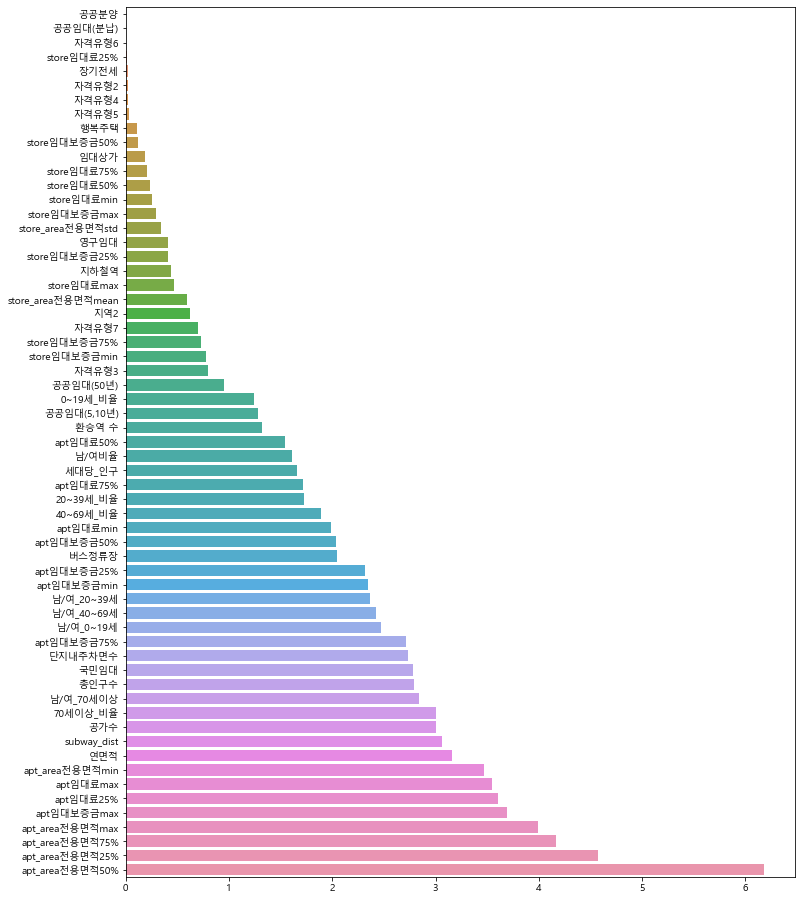

In [101]:
mod = modeling(train1,test1,'등록차량수/총세대수','catboost')
mod.training()
res = mod.model()
pred = mod.testing()

In [103]:
test1['등록차량수'] = pred
test1 = test1[['단지코드','등록차량수']]
test1.head()

,단지코드,등록차량수
0,C1072,897.8731
1,C1128,"1,612.3609"
2,C1456,741.6996
3,C1840,744.4392
4,C1332,"1,518.0402"


In [222]:
# 임대료 임대보증금 quantile/ 자격유형 0, 1 / area 아파트기준만 / area quantile/ 총세대수 관련 모든 변수 제거/ 환승역 수 dummy
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
pr = preprocess(train,test,['지역','단지명','도로명주소','위도','경도','subway_name'])
train2,test2 = pr.final()

(414, 27)
====train done====
(173, 27)
====test done====


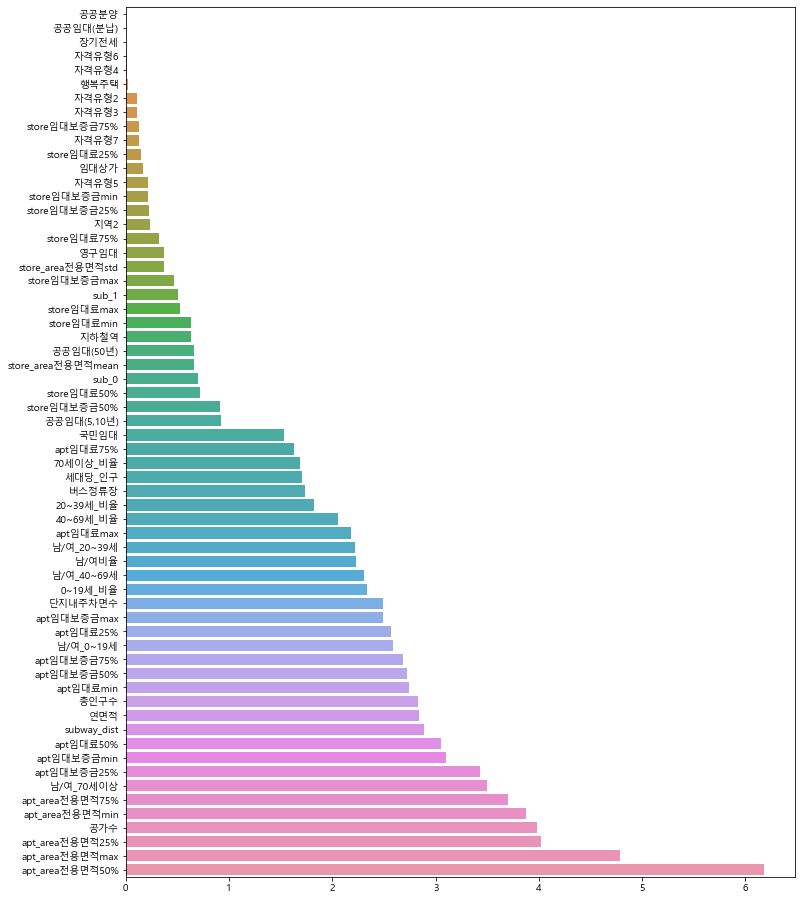

In [223]:
#첫번째방법에서 임대구분 count, 지하철역 dummy
mod = modeling(train2,test2,'등록차량수/총세대수','catboost')
mod.training()
res2 = mod.model()
pred2 = mod.testing()

In [224]:
res2

108.94490469668702

In [232]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명',
       '도로명주소', '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수',
       '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세',
       '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율',
       '세대당_가능주차면수', '자격유형카테고리'],
      dtype='object')

In [239]:
# 두번째 + 임대구분 세대수 + 공가수 총세대수 포함 + y는 등록차량수
# train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']

train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

pr = preprocess(train,test,['지역','단지명','도로명주소','위도','경도','subway_name'])
train3,test3 = pr.final()

(414, 28)
====train done====
(147, 27)
====test done====


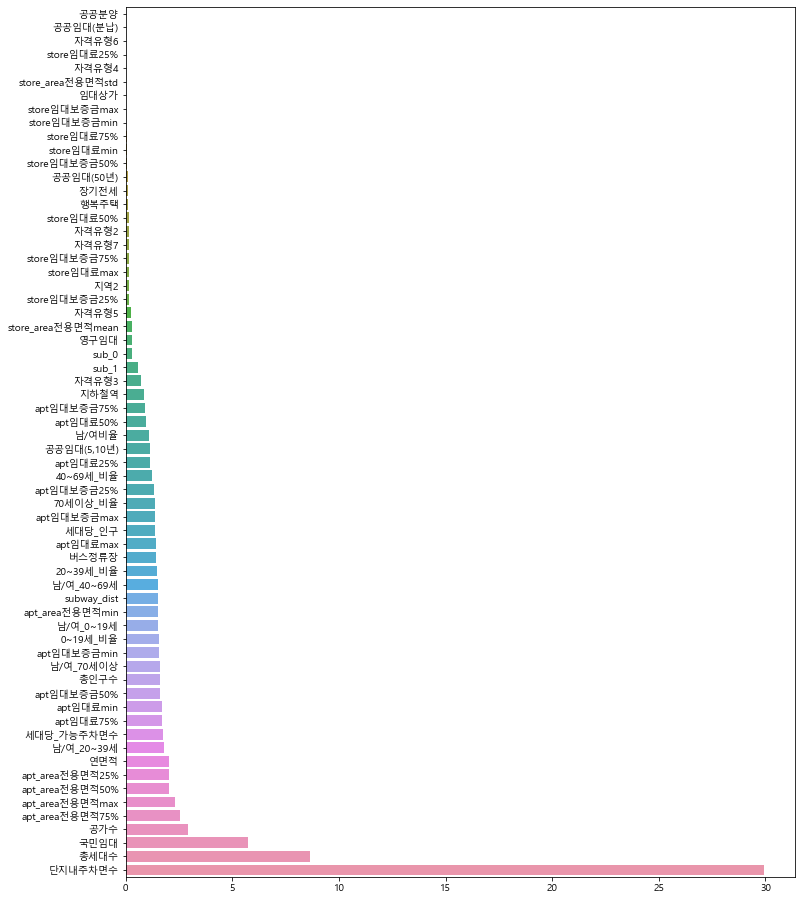

In [263]:
mod = modeling(train3,test3,'등록차량수','catboost')
mod.training()
res3 = mod.model()
pred3 = mod.testing()

In [249]:
cb = cb.loc[-sub['code'].isin(['C2675', 'C2335', 'C1327']),:].reset_index(drop=True)

In [244]:
# 3번 + 상가 area quantile
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

pr = preprocess(train,test,['지역','단지명','도로명주소','위도','경도','subway_name'])
train4,test4 = pr.final()

(414, 28)
====train done====
(147, 27)
====test done====


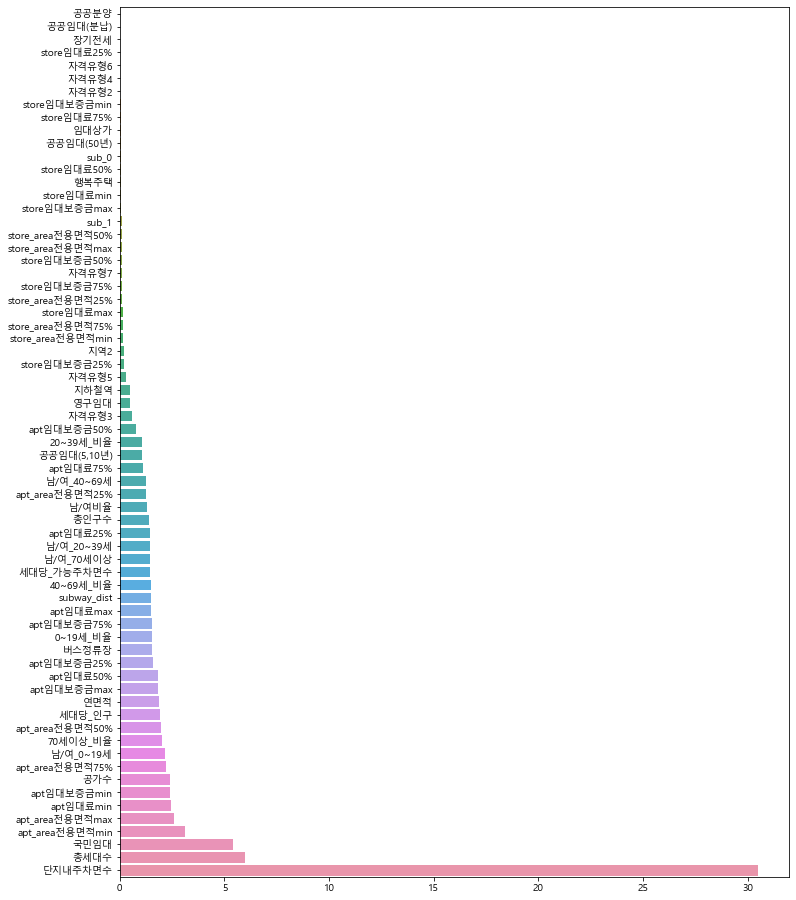

In [245]:
mod = modeling(train4,test4,'등록차량수','catboost')
mod.training()
res4 = mod.model()
pred4 = mod.testing()

In [246]:
res4

113.04414578859712

(414, 27)
====train done====
(173, 27)
====test done====


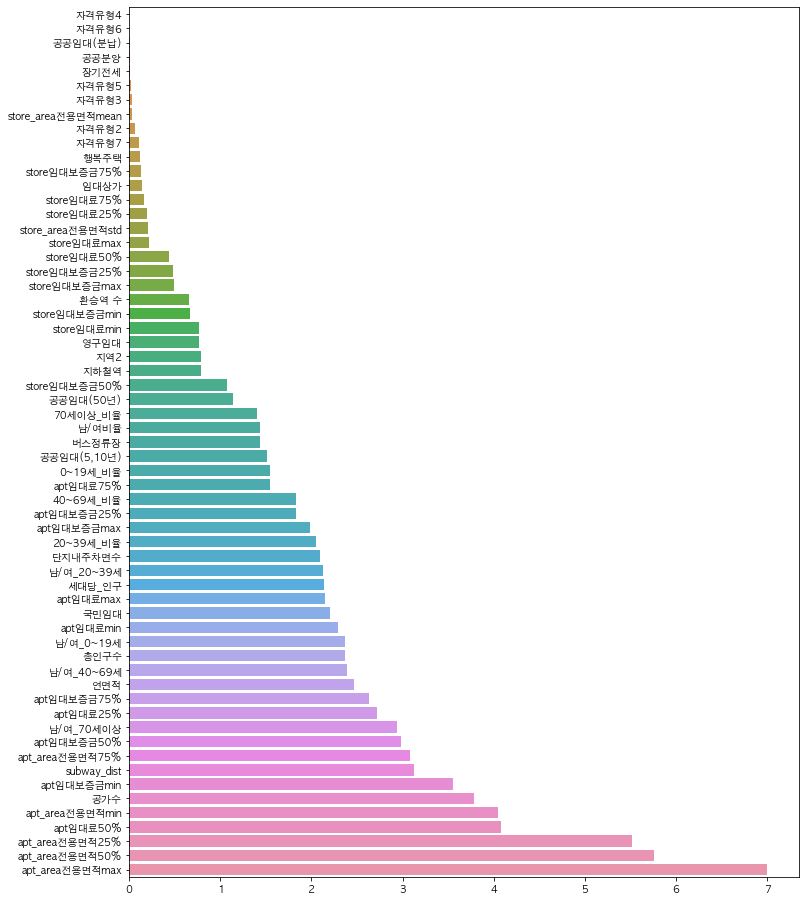

In [56]:
#첫번째 영구임대 임대료 임대보증금 2배
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
pr = preprocess(train,test,['지역','단지명','도로명주소','위도','경도','subway_name'])
train5,test5 = pr.final()
mod = modeling(train5,test5,'등록차량수/총세대수','catboost')
mod.training()
res5 = mod.model()
pred5 = mod.testing()

In [57]:
res5

110.06706626192516

## 순위 1등
- 임대료 임대보증금은 상가든 아파트는 quantile
- area aprt quantile
- area store mean std
- 공가수 비율

(414, 27)
====train done====
(173, 27)
====test done====


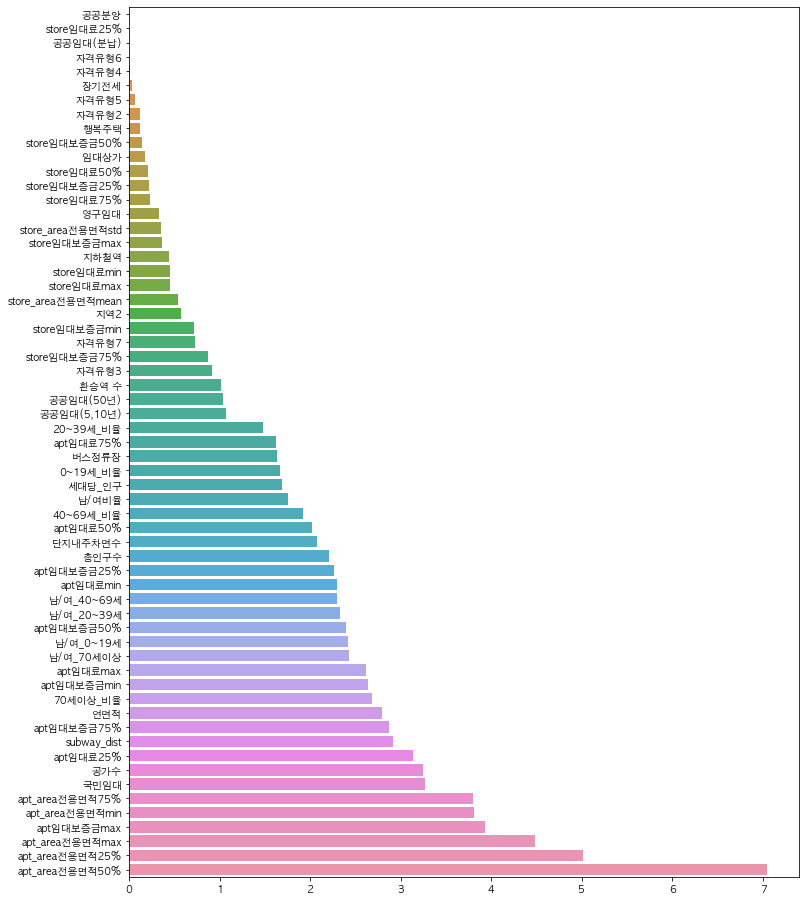

In [60]:
# 첫번째 + 공가수비율로 바꿈
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
pr = preprocess(train,test,['지역','단지명','도로명주소','위도','경도','subway_name'])
train6,test6 = pr.final()
mod = modeling(train6,test6,'등록차량수/총세대수','catboost')
mod.training()
res6 = mod.model()
pred6 = mod.testing()

In [61]:
res6

104.2601935787683

(414, 27)
====train done====
(173, 27)
====test done====


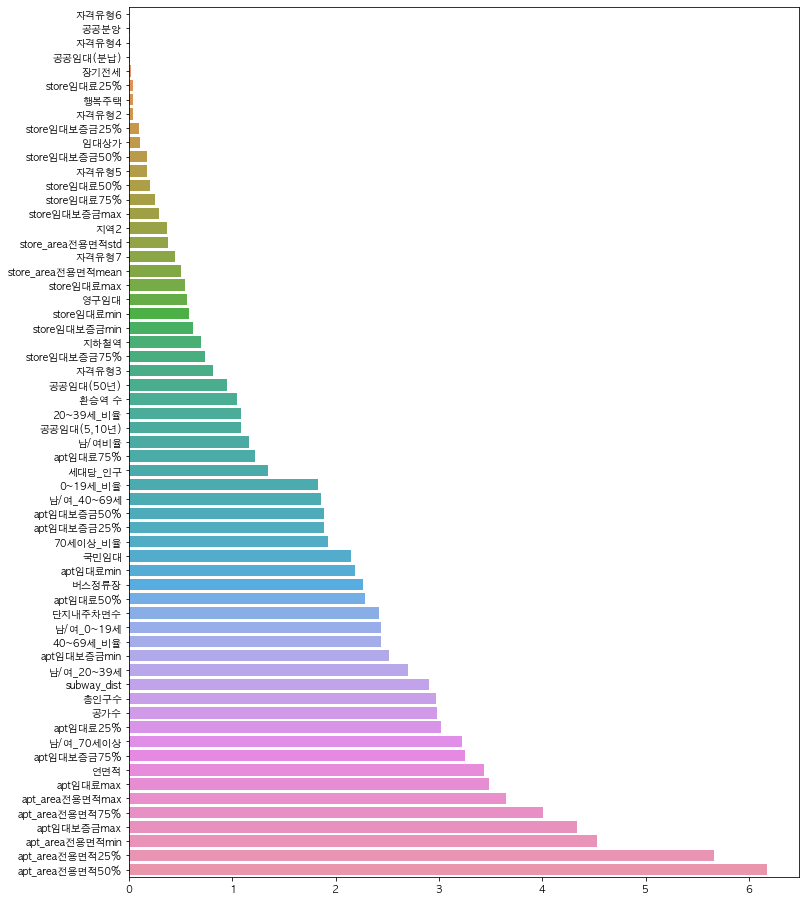

In [69]:
# 6번째 + 공급유형 count
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
pr = preprocess(train,test,['지역','단지명','도로명주소','위도','경도','subway_name'])
train7,test7 = pr.final()
mod = modeling(train7,test7,'등록차량수/총세대수','catboost')
mod.training()
res7 = mod.model()
pred7 = mod.testing()

In [70]:
res7

106.5982910969245

(414, 27)
====train done====
(173, 27)
====test done====


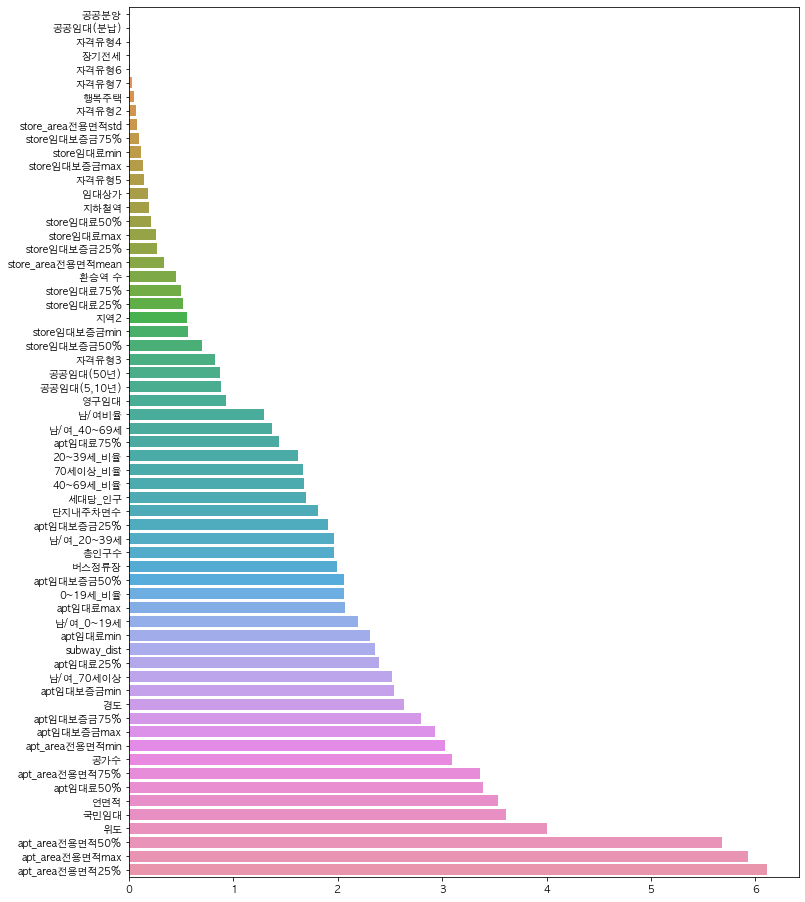

In [71]:
# 여섯번째 + 위도경도
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
pr = preprocess(train,test,['지역','단지명','도로명주소','subway_name'])
train8,test8 = pr.final()
mod = modeling(train8,test8,'등록차량수/총세대수','catboost')
mod.training()
res8 = mod.model()
pred8 = mod.testing()

In [73]:
res8

111.27982380925721

(414, 28)
====train done====
(147, 27)
====test done====


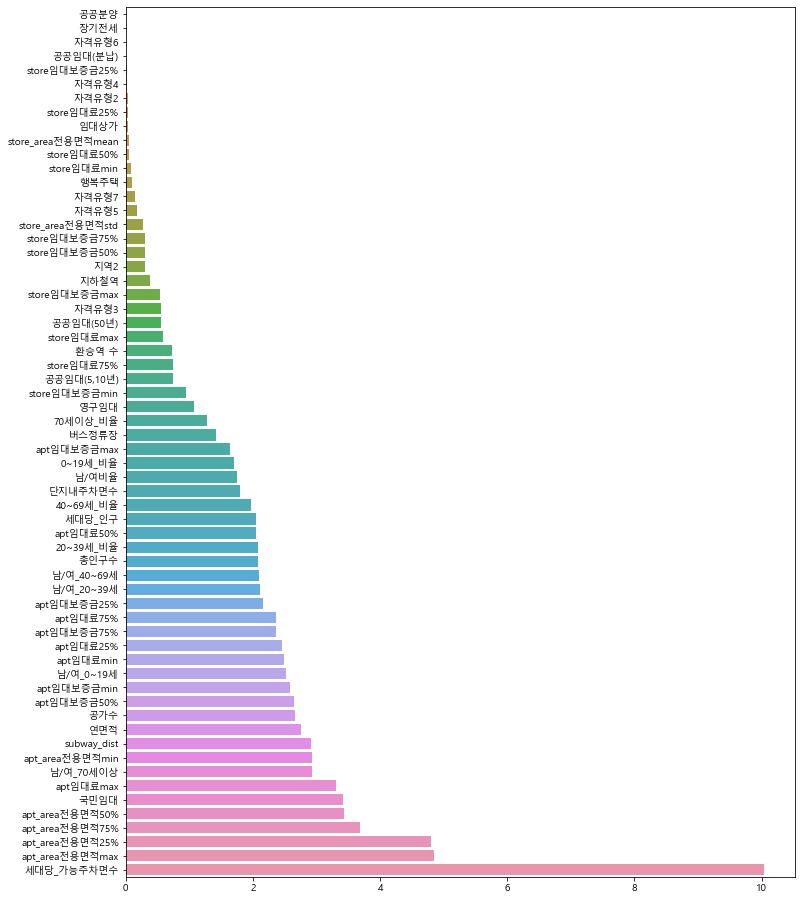

In [13]:
# 여섯번째 + 세대당가능주차면수
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']
pr = preprocess(train,test,['지역','단지명','도로명주소','위도','경도','subway_name'])
train9,test9 = pr.final()
mod = modeling(train9,test9,'등록차량수/총세대수','catboost')
mod.training()
res9 = mod.model()
pred9 = mod.testing()

In [14]:
res9

101.18309396198075

In [8]:
# 성능 bad
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']
pr = preprocess(train,test,['지역','단지명','도로명주소','위도','경도','subway_name'])
train10,test10 = pr.final()

(414, 28)
====train done====
(147, 27)
====test done====


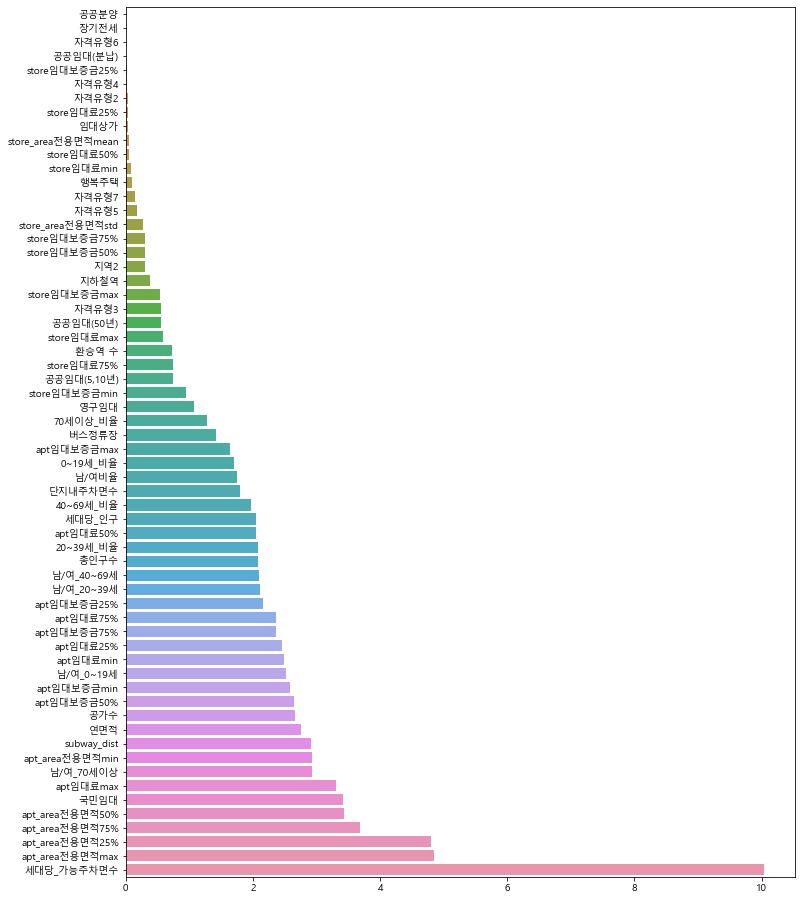

In [133]:
mod = modeling(train10,test10,'등록차량수/총세대수','catboost')
mod.training()
res10 = mod.model()
pred10 = mod.testing()

In [134]:
res10

101.18309396198075

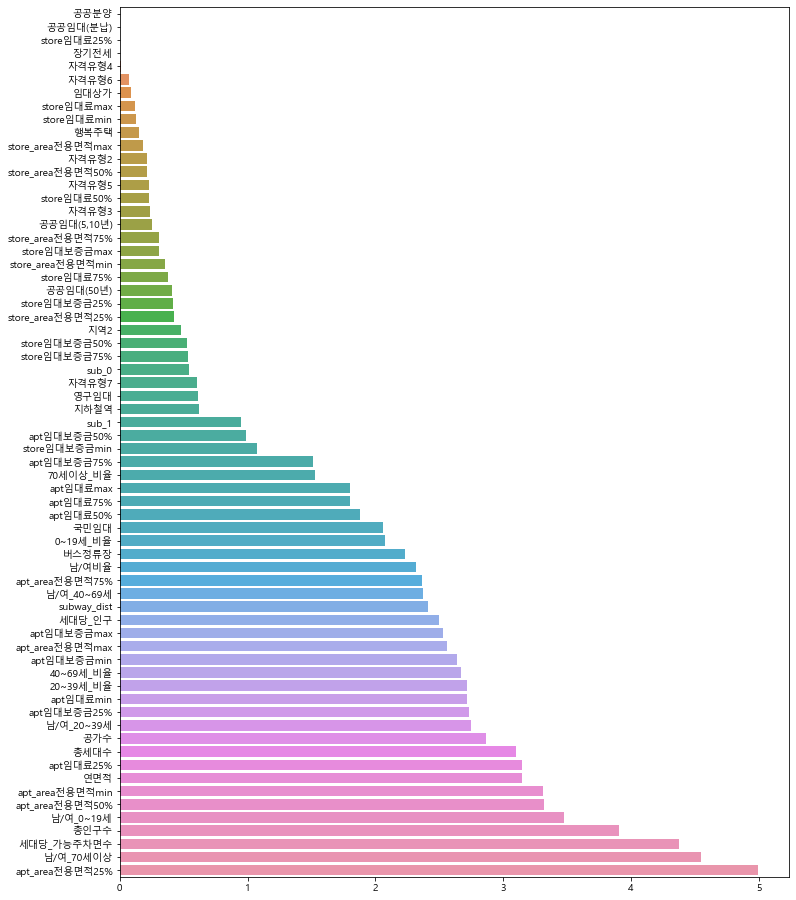

In [9]:
mod = modeling(train10,test10,'등록차량수/단지내주차면수','catboost')
mod.training()
res11 = mod.model()
pred11 = mod.testing()

In [10]:
res11

108.10155889226017

In [68]:
# store_area mean 임대료,임대보증금 quantile, 자격유형, 공급유형 제거, 상가 임대료/임대보증금
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']
pr = preprocess(train,test,['지역','단지명','도로명주소','위도','경도','subway_name'])
train12,test12 = pr.final()

(414, 28)
====train done====
(147, 27)
====test done====


In [69]:
mod = modeling(train12,test12,'등록차량수/단지내주차면수','dt')
mod.training()
res12 = mod.model()
pred12 = mod.testing()

ValueError: Number of features of the model must match the input. Model n_features is 42 and input n_features is 44 

In [48]:
res12

110.53610064758885

In [55]:
cb = myfunc()

In [59]:
mae(pred11,cb['num'])

165.9418590273487

In [188]:
sub['num'] = 0
sub_final = pd.merge(sub,tmp,left_on='code',right_on='단지코드',how='left').drop(['num','단지코드'],axis=1)

In [39]:
test10['등록차량수'] = pred11
tmp = test10[['단지코드','등록차량수']]
tmp.head()

,단지코드,등록차량수
0,C1072,825.7609
1,C1128,"1,471.5871"
2,C1456,665.9127
3,C1840,706.8961
4,C1332,"1,396.7006"


In [40]:
sub_final = pd.merge(sub,tmp,left_on='code',right_on='단지코드',how='left').drop(['num','단지코드'],axis=1).rename(columns={'등록차량수':'num'})

In [42]:
sub_final.to_csv("submit_cat.csv",index=False)

In [53]:
def myfunc():
    cb = pd.read_csv("0713_cb.csv")
    cb = cb.loc[-sub['code'].isin(['C2675', 'C2335', 'C1327']),:].reset_index(drop=True)
    return cb